In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Downloading and analyzing the dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


In [ ]:
df = pd.read_csv(path + "/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print("Length of dataset = ", len(df))
print("Number of non-fraudulent transactions = ", df['Class'].value_counts()[0])
print("Number of fraudulent transactions = ", df['Class'].value_counts()[1])
print(f"Degree of imbalance = {df['Class'].value_counts()[0] / df['Class'].value_counts()[1]:.2f}")

Length of dataset =  284807
Number of non-fraudulent transactions =  284315
Number of fraudulent transactions =  492
Degree of imbalance = 577.88


([<matplotlib.patches.Wedge at 0x7bb87901b3b0>,
 [Text(-1.0999838024749575, 0.0059694466019511215, 'Non-Fraudulent'),
  Text(1.099983802996819, -0.005969350438309128, 'Fraudulent')],
 [Text(-0.5999911649863404, 0.0032560617828824297, '99.83%'),
  Text(0.5999911652709922, -0.0032560093299867964, '0.17%')])

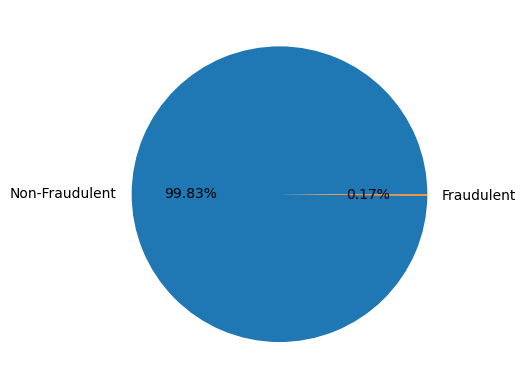

In [ ]:
plt.pie(df['Class'].value_counts(), labels=['Non-Fraudulent', 'Fraudulent'], autopct='%1.2f%%')

We see that a vast majority of elements are of class 0 (non-fraudulent). Hence, the datset is highly imbalanced.

# The baseline model (without resampling)

In [ ]:
fraudulent_set = df[df['Class'] == 1].to_numpy()
non_fraudulent_set = df[df['Class'] == 0].to_numpy()
y_fraudulent = np.ones(len(fraudulent_set))
y_non_fraudulent = np.zeros(len(non_fraudulent_set))
x_fraudulent = fraudulent_set[:, :-1]
x_non_fraudulent = non_fraudulent_set[:, :-1]

#train test split used separately on fraudulent and non-fraudulent data to preserve imbalance
x_fraudulent_train, x_fraudulent_test, y_fraudulent_train, y_fraudulent_test = train_test_split(x_fraudulent, y_fraudulent, test_size=0.2, random_state=42)
x_non_fraudulent_train, x_non_fraudulent_test, y_non_fraudulent_train, y_non_fraudulent_test = train_test_split(x_non_fraudulent, y_non_fraudulent, test_size=0.2, random_state=42)

#Concatenate to get the final train and test datasets
x_train = np.concatenate((x_fraudulent_train, x_non_fraudulent_train))
x_test = np.concatenate((x_fraudulent_test, x_non_fraudulent_test))
y_train = np.concatenate((y_fraudulent_train, y_non_fraudulent_train))
y_test = np.concatenate((y_fraudulent_test, y_non_fraudulent_test))

In [ ]:
baseline_model = LogisticRegression()
baseline_model.fit(x_train, y_train)
y_preds = baseline_model.predict(x_test)

report = classification_report(y_test, y_preds, target_names = ['Non-Fraudulent', 'Fraudulent'], digits=3)

#Dictionary for storing metrics of minority class
metrics = {'baseline': report.split('\n')[3].split()[1:4]}

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Obsevation
Accuracy is a misleading metric here since although the model performs poorly on fraudelent data, the accuracy is high. This is because since 99.83% of the transactions are non-fraudulent, the model model can acquire high accuracy by classifying most of the transactions as non-fraudulent (even the fraudulent ones). Therefore, the performance on the minority class (especially recall) is a better metric for evaluating the model.

# GMM (Gaussian Mixture Model)
GMM model works on the assumption that each cluster follows a multivariate Gaussian distribution. Clustering is performed on the minority class. Oversampling is done from the clusters (maintaining the proportion of datapoints from each cluster). In SMOTE, for each point in the minority class, a number of nearest neighbours (belonging to minority class) are identified. Synthetic points are then interpolated between the original point and the neighbours.

A drawback of SMOTE is that it can amplify noise in the dataset. If a point is mislabelled, a large number of mislabelled points are generated. In GMM, noisy points are assigned lower probabilities.

GMM is also better than other clustering methods since it can account for elliptical clusters, enabling it to capture complex structures. K-means clustering creates spherical clusters. GMM is also better for sampling since it forms clusters based on the assumption that the clusters follow a Gaussian distribution.

## Determining optimal number of clusters
Plots of Akaike Information Criteon (AIC) and Bayesian Information Criterion (BIC) are used to determine optimal number of clusters.

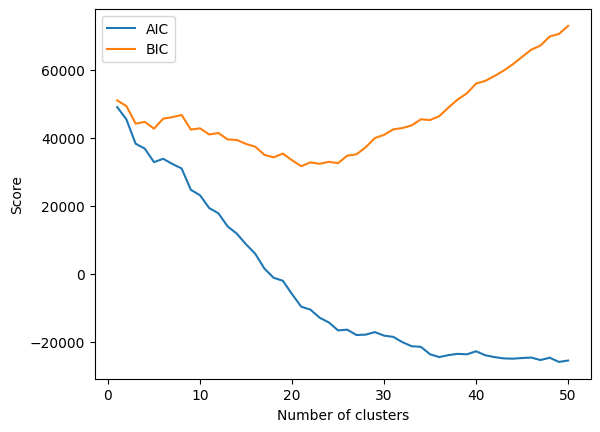

In [ ]:
#Plotting AIC and BIC
aic = []
bic = []
n_components = np.arange(1, 51)
for n in n_components:
  gmm = GaussianMixture(n_components=n, random_state=42)
  gmm.fit(x_fraudulent_train)
  aic.append(gmm.aic(x_fraudulent_train))
  bic.append(gmm.bic(x_fraudulent_train))

plt.figure()
plt.plot(n_components, aic, label='AIC')
plt.plot(n_components, bic, label='BIC')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

From the plot, we choose 25 as the number of clusters.

In [ ]:
n_optimal = 25
gmm = GaussianMixture(n_components=n_optimal, random_state=42)
gmm.fit(x_fraudulent_train)

GaussianMixture(n_components=25, random_state=42)

GMM samples from a multivariate Gaussian distribution from each cluster. If the clustering is done correctly, the synthetic dataset would have a distribution identical to that of the original dataset.

In [ ]:
samples = gmm.sample(n_samples=len(x_non_fraudulent_train))
x_train_gmm = np.concatenate((samples[0], x_non_fraudulent_train))
y_train_gmm = np.concatenate((np.ones(len(samples[0])), np.zeros(len(samples[0]))))

#Verifying that the dataset is balanced
print("Number of fraudulent samples = ", len(samples[0]))
print("Number of non-fraudulent samples = ", len(x_non_fraudulent_train))

Number of fraudulent samples =  227452
Number of non-fraudulent samples =  227452


# GMM with CBU

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_non_fraudulent_train)

resample_size = 1000
non_fraud_samples = []
for i in range(kmeans.n_clusters):
  cluster = x_non_fraudulent_train[kmeans.labels_ == i]
  # Sampling from each cluster maintaining the proportion of points from each cluster
  indices = np.random.randint(0, len(cluster), resample_size*len(cluster)//len(x_non_fraudulent_train))
  non_fraud_samples.append(cluster[indices])

non_fraud_samples = np.concatenate(non_fraud_samples, axis=0)
fraud_samples = gmm.sample(resample_size)[0]
x_train_gmm_cbu = np.concatenate((fraud_samples, non_fraud_samples))
y_train_gmm_cbu = np.concatenate((np.ones(len(fraud_samples)), np.zeros(len(non_fraud_samples))))

#Verifying that the dataset is balanced
print("Number of fraudulent samples = ", len(fraud_samples))
print("Number of non-fraudulent samples = ", len(non_fraud_samples))

Number of fraudulent samples =  1000
Number of non-fraudulent samples =  998


# Performance

## Without CBU

In [ ]:
model_gmm = LogisticRegression()
model_gmm.fit(x_train_gmm, y_train_gmm)
y_preds = model_gmm.predict(x_test)

report = classification_report(y_test, y_preds, target_names = ['Non-Fraudulent', 'Fraudulent'], digits=3)
metrics['gmm'] = report.split('\n')[3].split()[1:4]
print(report)

                precision    recall  f1-score   support

Non-Fraudulent      1.000     0.967     0.983     56863
    Fraudulent      0.047     0.939     0.089        99

      accuracy                          0.967     56962
     macro avg      0.523     0.953     0.536     56962
  weighted avg      0.998     0.967     0.981     56962



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## With CBU

In [ ]:
model_gmm_cbu = LogisticRegression()
model_gmm_cbu.fit(x_train_gmm_cbu, y_train_gmm_cbu)
y_preds = model_gmm_cbu.predict(x_test)

report = classification_report(y_test, y_preds, target_names = ['Non-Fraudulent', 'Fraudulent'], digits=3)
metrics['gmm_cbu'] = report.split('\n')[3].split()[1:4]
print(report)

                precision    recall  f1-score   support

Non-Fraudulent      1.000     0.970     0.985     56863
    Fraudulent      0.052     0.949     0.099        99

      accuracy                          0.970     56962
     macro avg      0.526     0.960     0.542     56962
  weighted avg      0.998     0.970     0.983     56962



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Analysis
GMM significantly increases the recall on the minority class. CBU slightly improves the recall. The precision is low because a vast majority of transactions in the dataset are non-fraudulent. Therefore, if even a small percentage of the majority class is misclassifed, the precision is greatly reduced. However, in this problem, recall is more important than precision (since allowing fraudulent transactions has greater consequences than blocking a legitimate transaction).

In [ ]:
#Summary table
summary_table = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-Score'])
summary_table['Model'] = ['Baseline', 'GMM without CBU', 'GMM with CBU']
summary_table['Precision'] = float(metrics['baseline'][0]), float(metrics['gmm'][0]), float(metrics['gmm_cbu'][0])
summary_table['Recall'] = float(metrics['baseline'][1]), float(metrics['gmm'][1]), float(metrics['gmm_cbu'][1])
summary_table['F1-Score'] = float(metrics['baseline'][2]), float(metrics['gmm'][2]), float(metrics['gmm_cbu'][2])
summary_table

,Model,Precision,Recall,F1-Score
0,Baseline,0.653,0.626,0.639
1,GMM without CBU,0.047,0.939,0.089
2,GMM with CBU,0.052,0.949,0.099


# Recommendation
GMM with CBU is recommended since it has a high recall on fraudulent transactions. CBU reduces the sample size has hence reduces the time to train the dataset. GMM is also theoretically better at sampling than other clustering-based methods since it forms clusters based on the assumption that the clusters follow a Gaussian distribution.